In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths

In [9]:
# Define a function to generate a template signal
def generate_template_signal(frequency, duration, sample_rate):
    time = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
    signal = chirp(time, f0=100, f1=frequency, t1=duration, method='linear')
    return signal

In [10]:
# Define a function to perform matched filtering on a time series
def matched_filter(time_series, template_signal, sample_rate, threshold):
    # Define the time lags to search over
    lag_time = np.arange(-len(template_signal), len(time_series)) / sample_rate

    # Initialize arrays to store the power and location of the maximum power
    power = np.zeros(len(lag_time))
    max_power_index = 0

    # Slide the template signal over the time series and calculate the power at each time lag
    for i, lag in enumerate(lag_time):
        shifted_template_signal = np.roll(template_signal, int(round(lag * sample_rate)))
        power[i] = np.abs(np.dot(shifted_template_signal, time_series)) ** 2

        # Update the location of the maximum power
        if power[i] > power[max_power_index]:
            max_power_index = i

    # Apply a threshold to the power and find the peaks
    thresholded_power = power - threshold
    peaks, _ = find_peaks(thresholded_power, distance=1000)

    # Calculate the width and height of each peak
    peak_properties = peak_widths(thresholded_power, peaks)
    peak_width = peak_properties[0]
    peak_height = peak_properties[1]

    # Plot the power and thresholded power as a function of time lag
    fig, ax = plt.subplots()
    ax.plot(lag_time, power, label='Power')
    ax.plot(lag_time, thresholded_power, label='Thresholded Power')
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(lag_time[max_power_index], color='r', linestyle='--', label='Max Power')
    ax.set_xlabel('Time Lag (s)')
    ax.set_ylabel('Power')
    ax.legend()
    
    # Return the time lag and power of the maximum power and the location, width, and height of each peak
    return lag_time[max_power_index], power[max_power_index], peaks, peak_width, peak_height


In [11]:
# Load the data from an external dataset
data = np.loadtxt('dataset.txt', delimiter=',')

# Extract the time and signal from the data
time = data[:, 0]
signal = data[:, 1]

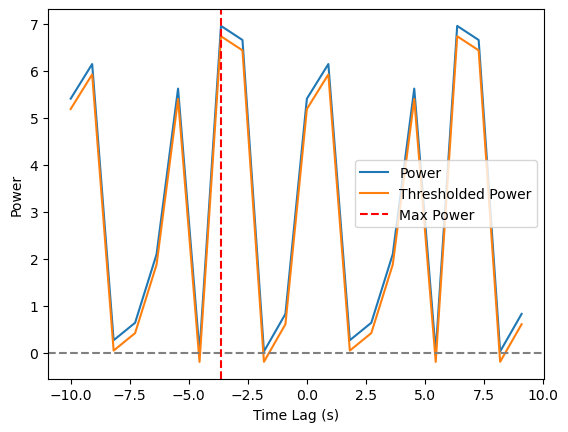

In [12]:
# Generate a template signal and perform matched filtering
duration = np.max(time) - np.min(time)
sample_rate = len(time) / duration
frequency = 400 # Hz
template_signal = generate_template_signal(frequency, duration, sample_rate)
threshold = 0.1 * np.max(np.abs(signal))
max_power_lag, max_power, peaks, peak_width, peak_height = matched_filter(signal, template_signal, sample_rate, threshold)

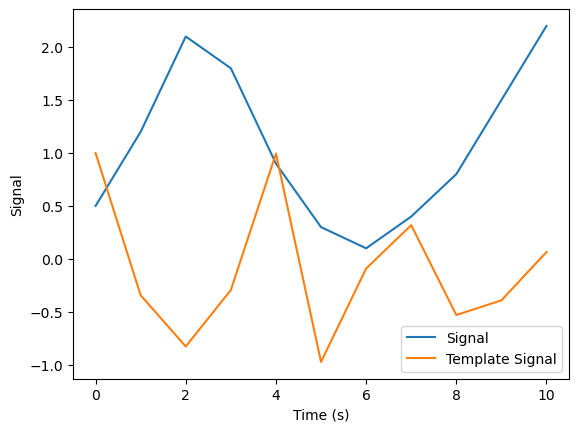

In [13]:
# Plot the matched filter output
fig, ax = plt.subplots()
ax.plot(time, signal, label='Signal')
ax.plot(time, template_signal, label='Template Signal')
for i, peak in enumerate(peaks):
    if peak < len(time) and peak < len(signal):
        ax.plot(time[peak], signal[peak], 'rx', label=f'Peak {i+1}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal')
ax.legend()

plt.show()